In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [2]:
import numpy as np
import os
import gzip

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [11]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
# print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

(20640, 8)
(20640,)


In [12]:
from sklearn.model_selection import train_test_split
# 注意housing本身的转变 以及train_test_split参数设置
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [ ]:
# 理解Dense在做什么
layer = keras.layers.Dense(100, input_shape=[None, 5])
layer(tf.zeros([10, 5]))
# 结果：<tf.Tensor: id=29, shape=(10, 100), dtype=float32, numpy=
# 为什么是(10, 100)啊？？？？ 不应该是(100, 10)吗？
#layer.variables
# kernel -> w，bias -> b
# Dense：全连接层  x * w + b

# layer.trainable_variables

# 查看其他方法
# help(layer)

In [16]:
# customized dense layer
# 用类的方式实现
class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        # 确定层单元数
        self.units = units
        # activation: Activation function, such as tf.nn.relu, or string name of built-in activation function, such as "relu"
        self.activation = keras.layers.Activation(activation)
        # 继承父类的参数
        super(CustomizedDenseLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        "构建所需要的参数"
        # add_weight父类Layer中的子方法，帮助我们得到一个变量
        # Dense：全连接层  x * w + b  input_shape=[None, a]  output_shape=[None, b]
        # output_shape就是units， kernel的shape=[a, b]
        # initializer 初始化方法
        self.kernel = self.add_weight(name = 'kernel', shape = (input_shape[1], self.units),
                                      initializer = 'uniform', trainable = True)
        self.bias = self.add_weight(name = 'bias', shape = (self.units), 
                                    initializer = 'zeros', trainable = True)
        super(CustomizedDenseLayer, self).build(input_shape)
    def call(self, x):
        "完成正向计算"
        return self.activation(x @ self.kernel + self.bias)

model = keras.models.Sequential([
    CustomizedDenseLayer(30, activation='relu', input_shape=x_train.shape[1:]),
    CustomizedDenseLayer(1)
])
model.summary()
model.compile(loss='mse', optimizer='adam',
              metrics=['mse'])
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
customized_dense_layer_4 (Cu (None, 30)                270       
_________________________________________________________________
customized_dense_layer_5 (Cu (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [17]:
def draw_learning_curve(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid()
    plt.ylim(0, 1)
    plt.show()

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 122us/sample - loss: 1.8915 - mse: 1.8915 - val_loss: 0.6531 - val_mse: 0.6531
Epoch 2/10
11610/11610 [==============================] - 1s 46us/sample - loss: 0.5089 - mse: 0.5089 - val_loss: 0.4813 - val_mse: 0.4813
Epoch 3/10
11610/11610 [==============================] - 1s 47us/sample - loss: 0.4361 - mse: 0.4361 - val_loss: 0.4464 - val_mse: 0.4464
Epoch 4/10
11610/11610 [==============================] - ETA: 0s - loss: 0.4228 - mse: 0.422 - 1s 46us/sample - loss: 0.4227 - mse: 0.4227 - val_loss: 0.4470 - val_mse: 0.4470
Epoch 5/10
11610/11610 [==============================] - 1s 46us/sample - loss: 0.4150 - mse: 0.4150 - val_loss: 0.4451 - val_mse: 0.4451
Epoch 6/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.4077 - mse: 0.4077 - val_loss: 0.4192 - val_mse: 0.4192
Epoch 7/10
11610/11610 [==============================] - 1s 46us/sample - los

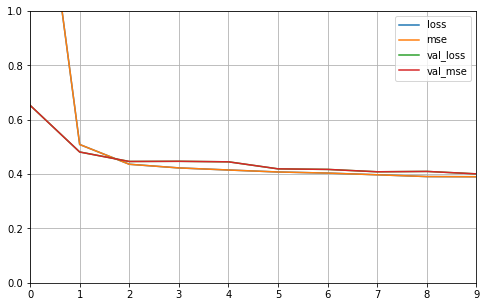

In [18]:
history = model.fit(x_train_scaled, y_train,
                   validation_data = [x_valid_scaled, y_valid],
                   epochs=10, callbacks=callbacks)
draw_learning_curve(history)

In [ ]:
model.evaluate(x_test_scaled, y_test)

Dense带参数， 若是不带参数的简单层次
可以用lambda定义层次
softplus激活函数： log(1 + e^x)

In [21]:
customized_softplus = keras.layers.Lambda(lambda x : tf.nn.softplus(x))
print(customized_softplus([-10., -5., 0., 5., 10.]))

tf.Tensor([4.5417706e-05 6.7153489e-03 6.9314718e-01 5.0067153e+00 1.0000046e+01], shape=(5,), dtype=float32)


In [24]:
model = keras.models.Sequential([
    CustomizedDenseLayer(30, activation='relu', input_shape=x_train.shape[1:]),
    CustomizedDenseLayer(1),
    customized_softplus
    # 等于 keras.layers.Dense(1, activation='softplus')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
customized_dense_layer_6 (Cu (None, 30)                270       
_________________________________________________________________
customized_dense_layer_7 (Cu (None, 1)                 31        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
